In [92]:
import os

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import copy

import time

import torch.optim as optim
#from dataset import train_dataloader, val_dataloader
#from dataset import train_dataset, val_dataset
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np

from sklearn.model_selection import cross_val_score

import pickle

In [2]:
main_dir = os.path.abspath('..') # os.path.join(os.getcwd())
data_dir = os.path.join(main_dir, "Data")
shapefiles_dir = os.path.join(main_dir, data_dir, "shapefiles")

In [3]:
pd.options.display.max_columns = None

In [4]:
pre_covid_data = pd.read_csv(os.path.join(data_dir, "Merged", "precovid_crime_micro_geo_11_29_2021.csv"), index_col=False)
del pre_covid_data['date']
del pre_covid_data[pre_covid_data.columns[0]]
pre_covid_data.head()

,SHIFT,OFFENSE,WARD,LATITUDE,LONGITUDE,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
0,MIDNIGHT,THEFT F/AUTO,5.0,38.918707,-76.962533,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.127080,0.674769,0.077614
1,MIDNIGHT,ASSAULT W/DANGEROUS WEAPON,6.0,38.907643,-77.009053,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.191281,0.079607,0.049559
2,MIDNIGHT,THEFT F/AUTO,6.0,38.901323,-77.016914,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.083639,0.124886,0.068719
3,DAY,THEFT F/AUTO,6.0,38.883239,-77.018730,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.135380,0.296590,0.074763
4,DAY,THEFT/OTHER,5.0,38.920933,-76.997157,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0.084503,0.849526,0.047963


In [5]:
del pre_covid_data["SHIFT"]
del pre_covid_data["OFFENSE"]

pre_covid_data['WARD'] = pre_covid_data['WARD'].astype(int)

In [6]:
del pre_covid_data["ward_1"]
del pre_covid_data["ward_2"]
del pre_covid_data["ward_3"]
del pre_covid_data["ward_4"]
del pre_covid_data["ward_5"]
del pre_covid_data["ward_6"]
del pre_covid_data["ward_7"]
del pre_covid_data["ward_8"]

In [7]:
pre_covid_data

,WARD,LATITUDE,LONGITUDE,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
0,5,38.918707,-76.962533,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.127080,0.674769,0.077614
1,6,38.907643,-77.009053,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.191281,0.079607,0.049559
2,6,38.901323,-77.016914,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.083639,0.124886,0.068719
3,6,38.883239,-77.018730,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.135380,0.296590,0.074763
4,5,38.920933,-76.997157,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0.084503,0.849526,0.047963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104354,6,38.902514,-77.001305,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.138408,0.513213,0.030329
104355,5,38.924202,-76.960627,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1.039210,0.809993,0.124818
104356,8,38.840647,-77.004730,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.559830,0.569863,0.005769
104357,5,38.905031,-76.995529,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.252021,0.904808,0.062211


In [8]:
del pre_covid_data["total_cases"]
del pre_covid_data["daily_cases"]
del pre_covid_data["daily_death"]
del pre_covid_data["OUT_POSITIVE_QUARANTINE_PSMPD"]

del pre_covid_data['LATITUDE']
del pre_covid_data['LONGITUDE']

In [9]:
pre_covid_data.isna().sum()

WARD                          0
MO                            0
TU                            0
WE                            0
TH                            0
FR                            0
SA                            0
SU                            0
JAN                           0
FEB                           0
MAR                           0
APR                           0
MAY                           0
JUN                           0
JUL                           0
AUG                           0
SEP                           0
OCT                           0
NOV                           0
DEC                           0
ARSON                         0
ASSAULT W/DANGEROUS WEAPON    0
BURGLARY                      0
HOMICIDE                      0
MOTOR VEHICLE THEFT           0
ROBBERY                       0
SEX ABUSE                     0
THEFT F/AUTO                  0
THEFT/OTHER                   0
DAY                           0
EVENING                       0
MIDNIGHT

In [10]:
# WARD, DISTRICT, total_cases, daily_cases/deaths, OUT_POSITIVE_QUARANTINE_PSMPD, DAYS (MO-SUN), SHIFT, MONTH => CRIME_CLASS (9)

In [11]:
X = pre_covid_data.loc[:, pre_covid_data.columns != 'WARD'].values
y = pre_covid_data['WARD'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [12]:
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("")
print("X_test.shape", X_test.shape)
print("X_test.shape", X_test.shape)

X_train.shape (73051, 34)
y_train.shape (73051,)

X_test.shape (31308, 34)
X_test.shape (31308, 34)


# Using Standard Scaler on Data:

In [13]:
Stand_scaler = StandardScaler() # or MinMaxScaler()
Stand_scaler.fit(X_train)

X_train_Stand_scaled = Stand_scaler.transform(X_train)
X_test_Stand_scaled = Stand_scaler.transform(X_test)

print(X_train_Stand_scaled[:2])

print(X_test_Stand_scaled[:2])

[[-0.40982482 -0.40642421  2.48372524 -0.3985713  -0.41532269 -0.41464279
  -0.41021204 -0.34253388 -0.31157023 -0.28584647 -0.27760964 -0.29320565
   3.37770144 -0.30230536 -0.30684056 -0.30136048 -0.30926442 -0.29339832
  -0.29501881 -0.01433102 -0.22773976 -0.20976967 -0.06715851 -0.27404662
  -0.26001321 -0.08749626 -0.68881575  1.12522488 -0.74236674  1.14540822
  -0.51894535 -0.46231599  0.27609147  0.16474123]
 [-0.40982482  2.46048336 -0.40262102 -0.3985713  -0.41532269 -0.41464279
  -0.41021204 -0.34253388 -0.31157023 -0.28584647  3.60218032 -0.29320565
  -0.29605932 -0.30230536 -0.30684056 -0.30136048 -0.30926442 -0.29339832
  -0.29501881 -0.01433102 -0.22773976 -0.20976967 -0.06715851 -0.27404662
  -0.26001321 -0.08749626 -0.68881575  1.12522488 -0.74236674  1.14540822
  -0.51894535 -1.05896803 -0.0761797  -0.41514534]]
[[ 2.44006695 -0.40642421 -0.40262102 -0.3985713  -0.41532269 -0.41464279
  -0.41021204  2.91941925 -0.31157023 -0.28584647 -0.27760964 -0.29320565
  -0.2960

# Using MinMax Scaler with range between 0 and 1:

In [14]:
from sklearn.preprocessing import MinMaxScaler

MinMax_scaler = MinMaxScaler(feature_range=(0, 1))

MinMax_scaler = MinMax_scaler.fit(X_train)

X_train_MinMax_scaled = MinMax_scaler.transform(X_train)
X_test_MinMax_scaled = MinMax_scaler.transform(X_test)

print(X_train_MinMax_scaled[:2])
print(X_test_MinMax_scaled[:2])

[[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         1.
  0.         0.09632891 0.18446848 0.10544984]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         1.
  0.         0.02065927 0.12561248 0.06040662]]
[[1.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         1.
  0. 

# Grid Search for each:

# SVC (Support Vector Machine)

In [15]:
# with StandardScaler
curr_SVC_cls_w_StandScaler = SVC(C=41, kernel='rbf')

curr_SVC_cls_w_StandScaler.fit(X_train_Stand_scaled, y_train)
curr_y_pred_SVC_grid_with_StandScaler = curr_SVC_cls_w_StandScaler.predict(X_test_Stand_scaled)
y_true = y_test
print(f"Current C={41}")
print("    * Score is:", curr_y_pred_SVC_grid_with_StandScaler)
print("    * Accuracy:", round(accuracy_score(y_test, curr_y_pred_SVC_grid_with_StandScaler)*100, 2), "%")
print("    * Precision:", round(precision_score(y_test, curr_y_pred_SVC_grid_with_StandScaler,
                                    average='macro')*100, 2), "%")
print("    * Recall:", round(recall_score(y_test, curr_y_pred_SVC_grid_with_StandScaler,
                              average='macro')*100, 2), "%")

Current C=41
    * Score is: [2 5 2 ... 5 2 8]
    * Accuracy: 52.21 %
    * Precision: 51.53 %
    * Recall: 48.66 %


In [93]:
pickle.dump(curr_SVC_cls_w_StandScaler, open("SVC_cls_w_StandScaler_PreCOVID.sav", 'wb'))

In [91]:
# with MinMax
curr_SVC_cls_w_MinMax = SVC(C=41, kernel='rbf')

curr_SVC_cls_w_MinMax.fit(X_train_MinMax_scaled, y_train)
curr_y_pred_SVC_grid_with_MinMax = curr_SVC_cls_w_MinMax.predict(X_test_MinMax_scaled)
y_true = y_test
print(f"Current C={41}")
print("    * Score is:", curr_y_pred_SVC_grid_with_MinMax)
print("    * Accuracy:", round(accuracy_score(y_test, curr_y_pred_SVC_grid_with_MinMax)*100, 2), "%")
print("    * Precision:", round(precision_score(y_test, curr_y_pred_SVC_grid_with_MinMax,
                                    average='macro')*100, 2), "%")
print("    * Recall:", round(recall_score(y_test, curr_y_pred_SVC_grid_with_MinMax,
                              average='macro')*100, 2), "%")

Current C=41
    * Score is: [2 5 2 ... 2 2 8]
    * Accuracy: 47.04 %
    * Precision: 46.65 %
    * Recall: 42.98 %


In [94]:
pickle.dump(curr_SVC_cls_w_MinMax, open("SVC_cls_w_MinMax_PreCOVID.sav", 'wb'))

# Neural Network:

In [ ]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

In [16]:
X_train_Stand_scaled.shape

(73051, 34)

In [17]:
y_train

array([5, 3, 2, ..., 8, 6, 2])

In [18]:
X_train_Stand_scaled[0].shape[0]

34

In [38]:
class CrimeDataset(Dataset):
    
    def __init__(self, scaling_type="Standard_Scaler", learning_mode="train"):
        # Initialize data        
        if scaling_type == "Standard_Scaler":
            train_numpy_arr = X_train_Stand_scaled
            test_numpy_arr = X_test_Stand_scaled
        else: # do MinMax
            train_numpy_arr = X_train_MinMax_scaled
            test_numpy_arr = X_test_MinMax_scaled
            
        main_data = copy.deepcopy(train_numpy_arr)
        x_train_data, x_val_data, y_train_data, y_val_data = train_test_split(train_numpy_arr, y_train, test_size=0.2, random_state=1)
        x_test_data, y_test_data = test_numpy_arr, y_test
           
        if learning_mode == "test":
            print("Retreiving Test Dataset...")
            self.x_data = torch.from_numpy(x_test_data)
            self.y_data = torch.from_numpy(y_test_data-1)
        elif learning_mode == "val":
            print("Retreiving Validation Dataset...")
            self.x_data = torch.from_numpy(x_val_data)
            self.y_data = torch.from_numpy(y_val_data-1)
        else:
            print("Retreiving Train Dataset...")
            self.x_data = torch.from_numpy(x_train_data)
            self.y_data = torch.from_numpy(y_train_data-1)
            
        self.n_samples = self.x_data.shape[0]
            
    # here the first column is the class label, the rest are the features
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    # support indexing such that dataset[i] can be used to get i-th sample
    def __len__(self):
        print("  -n_samples =", self.n_samples)
        return self.n_samples

In [39]:
# Multiclass problem
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, hidden_size) 
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_size, hidden_size) 
        #self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_size, hidden_size) 
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(hidden_size, hidden_size) 
        #self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(hidden_size, hidden_size) 
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(hidden_size, hidden_size) 
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        #out = self.relu3(out)
        #out = self.linear4(out)
        #out = self.relu4(out)
        #out = self.linear5(out)
        #out = self.relu5(out)
        #out = self.linear6(out)
        #out = self.relu6(out)
        #out = self.linear7(out)
        #out = self.relu7(out)
        #out = self.linear8(out)
        # no softmax at the end
        return out

In [40]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [41]:
# training function
softmax = nn.Softmax(dim=1)

def fit(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0], data[1]
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data.float())
        #output_labels = []
        #for t in outputs:
        #    __, class_pred = torch.max(t, dim=0)
        #    output_labels.append(class_pred.item())
        #output_labels = torch.tensor(np.array(output_labels))
        output_probas = softmax(outputs)
        target = target.type(torch.LongTensor)
        loss = criterion(output_probas, target) #.long())
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [42]:
# validation function
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0], data[1]
            total += target.size(0)
            outputs = model(data.float())
            loss = criterion(outputs, target.type(torch.LongTensor))
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [43]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

In [44]:
type(X_train_MinMax_scaled)

numpy.ndarray

In [45]:
type(y_train)

numpy.ndarray

In [46]:
# traning and validation datasets and dataloaders
train_dataset = CrimeDataset(learning_mode="train")

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)


val_dataset = CrimeDataset(learning_mode="val")

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)


test_dataset = CrimeDataset(learning_mode="test")

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

Retreiving Train Dataset...
  -n_samples = 58440
  -n_samples = 58440
Retreiving Validation Dataset...
Retreiving Test Dataset...


In [54]:
epochs = 100
lr = 0.0001
perform_early_stopping = True
early_stopping = EarlyStopping()
hidden_size_ = 124
num_classes_ = len(set(y_train))

model = NeuralNet2(input_size=X_train_Stand_scaled[0].shape[0], hidden_size=hidden_size_, num_classes=num_classes_)
criterion = nn.CrossEntropyLoss()  # (applies Softmax)
optimizer = optim.Adam(model.parameters(), lr=lr)

# lists to store per-epoch loss and accuracy values
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if perform_early_stopping:
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 100
Training
  -n_samples = 58440


  8%|██████                                                                        | 141/1826 [00:00<00:02, 710.55it/s]

  -n_samples = 58440


1827it [00:02, 718.73it/s]                                                                                             


Validating
  -n_samples = 14611


 93%|████████████████████████████████████████████████████████████████████████▋     | 425/456 [00:00<00:00, 2147.02it/s]

  -n_samples = 14611


457it [00:00, 2135.50it/s]                                                                                             


Train Loss: 4.5533, Train Acc: 32.16
Val Loss: 4.8500, Val Acc: 38.29
Epoch 2 of 100
Training
  -n_samples = 58440


  4%|███                                                                            | 70/1826 [00:00<00:02, 686.28it/s]

  -n_samples = 58440


1827it [00:02, 664.36it/s]                                                                                             


Validating
  -n_samples = 14611


 93%|████████████████████████████████████████████████████████████████████████▊     | 426/456 [00:00<00:00, 2142.58it/s]

  -n_samples = 14611


457it [00:00, 2115.99it/s]                                                                                             


INFO: Early stopping counter 1 of 5
Train Loss: 4.4455, Train Acc: 40.59
Val Loss: 5.7646, Val Acc: 42.74
Epoch 3 of 100
Training
  -n_samples = 58440


  7%|█████▊                                                                        | 135/1826 [00:00<00:02, 679.12it/s]

  -n_samples = 58440


1827it [00:02, 664.36it/s]                                                                                             


Validating
  -n_samples = 14611


 93%|████████████████████████████████████████████████████████████████████████▊     | 426/456 [00:00<00:00, 2119.10it/s]

  -n_samples = 14611


457it [00:00, 2086.50it/s]                                                                                             


INFO: Early stopping counter 2 of 5
Train Loss: 4.4150, Train Acc: 43.46
Val Loss: 6.8636, Val Acc: 43.79
Epoch 4 of 100
Training
  -n_samples = 58440


  4%|██▉                                                                            | 68/1826 [00:00<00:02, 679.78it/s]

  -n_samples = 58440


1827it [00:02, 656.49it/s]                                                                                             


Validating
  -n_samples = 14611


 46%|███████████████████████████████████▉                                          | 210/456 [00:00<00:00, 2099.96it/s]

  -n_samples = 14611


457it [00:00, 2086.75it/s]                                                                                             


INFO: Early stopping counter 3 of 5
Train Loss: 4.4025, Train Acc: 44.27
Val Loss: 7.5746, Val Acc: 44.22
Epoch 5 of 100
Training
  -n_samples = 58440


  3%|██▌                                                                            | 58/1826 [00:00<00:03, 574.27it/s]

  -n_samples = 58440


1827it [00:02, 659.09it/s]                                                                                             


Validating
  -n_samples = 14611


 47%|████████████████████████████████████▉                                         | 216/456 [00:00<00:00, 2138.62it/s]

  -n_samples = 14611


457it [00:00, 2049.32it/s]                                                                                             


INFO: Early stopping counter 4 of 5
Train Loss: 4.3957, Train Acc: 44.73
Val Loss: 8.1702, Val Acc: 44.50
Epoch 6 of 100
Training
  -n_samples = 58440


  4%|██▉                                                                            | 69/1826 [00:00<00:02, 689.99it/s]

  -n_samples = 58440


1827it [00:02, 684.01it/s]                                                                                             


Validating
  -n_samples = 14611


 46%|████████████████████████████████████▎                                         | 212/456 [00:00<00:00, 2119.28it/s]

  -n_samples = 14611


457it [00:00, 2165.62it/s]                                                                                             

INFO: Early stopping counter 5 of 5
INFO: Early stopping
Training time: 0.293 minutes


In [55]:
y_train

array([5, 3, 2, ..., 8, 6, 2])

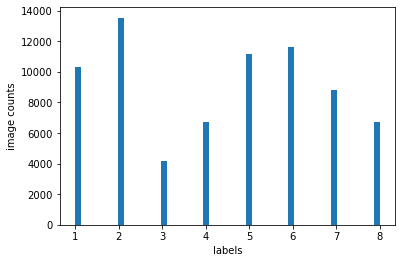

In [56]:
plt.hist(y_train, align='mid', range=(np.min(y_train), np.max(y_train)), bins=50)
plt.xlabel("labels")
plt.ylabel("image counts")
plt.show()

# KNN Classifier

In [57]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

### K Search:

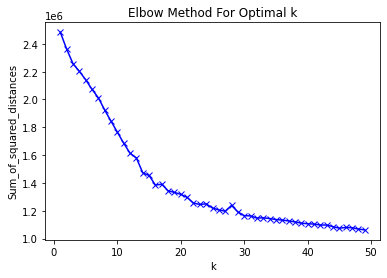

In [60]:
# Elbow using Standard Scaler
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train_Stand_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

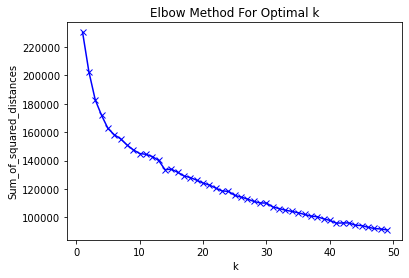

In [61]:
# Elbow using MinMax Scaler
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train_MinMax_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

Text(0, 0.5, 'Silhouette Score')

<Figure size 432x288 with 0 Axes>

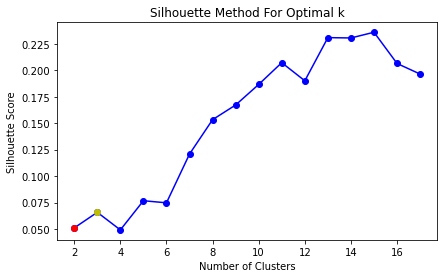

In [74]:
# Silhouette using Standard Scaler

import matplotlib.pyplot as plt
%matplotlib inline
X=X_train_Stand_scaled
# Variables to store silhouette score and inertia for different clusters
scores = []
from sklearn.metrics import silhouette_score
# Calculate silhouette scores and inertia for different number of clusters
for cluster_number in range(2,18):
  km = KMeans(n_clusters=k)
  km = KMeans(n_clusters=cluster_number, random_state=42).fit(X)
  scores.append(silhouette_score(X,km.labels_))
#plot the results
plt.clf()
plt.figure(figsize=(15,4))
#plot Silhouette Score
plt.subplot(121)
plt.plot(range(2,18), scores, 'bo-')
plt.plot(2, scores[0], 'ro-')
plt.plot(3, scores[1], 'yo-')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

Text(0, 0.5, 'Silhouette Score')

<Figure size 432x288 with 0 Axes>

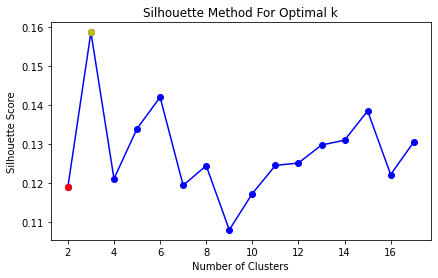

In [75]:
# Silhouette using MinMax Scaler
import matplotlib.pyplot as plt
%matplotlib inline
X=X_train_MinMax_scaled
# Variables to store silhouette score and inertia for different clusters
scores = []
from sklearn.metrics import silhouette_score
# Calculate silhouette scores and inertia for different number of clusters
for cluster_number in range(2,18):
  km = KMeans(n_clusters=k)
  km = KMeans(n_clusters=cluster_number, random_state=42).fit(X)
  scores.append(silhouette_score(X,km.labels_))
#plot the results
plt.clf()
plt.figure(figsize=(15,4))
#plot Silhouette Score
plt.subplot(121)
plt.plot(range(2,18), scores, 'bo-')
plt.plot(2, scores[0], 'ro-')
plt.plot(3, scores[1], 'yo-')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

### KNN Model:

In [33]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

In [88]:
# import sklearn
# sklearn.metrics.SCORERS.keys()

In [89]:
# Data with Standard Scaler HERE CONTINUE
kn_Stand_Scaler = KNeighborsClassifier(n_neighbors=15)
kn_Stand_Scaler.fit(X_train_Stand_scaled, y_train)

y_pred_KNN_with_StandScaler = kn_Stand_Scaler.predict(X_test_Stand_scaled)
y_true = y_test

print("KNN result (using Standard Scaler):")
#print("    * Score is:", score(y_pred_KNN_grid_with_StandScaler, y_test)
print("Score (Accuracy):", cross_val_score(kn_Stand_Scaler, X_test_Stand_scaled, y_test, cv=5, scoring='accuracy'))
print("    * Accuracy:", round(accuracy_score(y_test, y_pred_KNN_with_StandScaler)*100, 2), "%")
print("    * Precision:", round(precision_score(y_test, y_pred_KNN_with_StandScaler,
                                    average='macro')*100, 2), "%")
print("    * Recall:", round(recall_score(y_test, y_pred_KNN_with_StandScaler,
                              average='macro')*100, 2), "%")

KNN result (using Standard Scaler):
Score (F1-Score): [0.31491536 0.30405621 0.31715107 0.30953522 0.30474365]
    * Accuracy: 37.91 %
    * Precision: 38.32 %
    * Recall: 33.69 %


In [95]:
pickle.dump(kn_Stand_Scaler, open("kn_Stand_Scaler_PreCOVID.sav", 'wb'))

In [90]:
# Data with MinMax
kn_MinMax_Scaler = KNeighborsClassifier(n_neighbors=15)
kn_MinMax_Scaler.fit(X_train_MinMax_scaled, y_train)

y_pred_KNN_with_MinMaxScaler = kn_MinMax_Scaler.predict(X_test_MinMax_scaled)
y_true = y_test

print("KNN result (using MinMax Scaler):")
#print("    * Score is:", score(y_pred_KNN_with_MinMaxScaler, y_test)
print("Score (Accuracy):", cross_val_score(kn_MinMax_Scaler, X_test_MinMax_scaled, y_test, cv=5, scoring='accuracy'))
print("    * Accuracy:", round(accuracy_score(y_test, y_pred_KNN_with_MinMaxScaler)*100, 2), "%")
print("    * Precision:", round(precision_score(y_test, y_pred_KNN_with_MinMaxScaler,
                                    average='macro')*100, 2), "%")
print("    * Recall:", round(recall_score(y_test, y_pred_KNN_with_MinMaxScaler,
                              average='macro')*100, 2), "%")

KNN result (using MinMax Scaler):
Score: [0.3404663  0.34669435 0.35132546 0.33620827 0.33604855]
    * Accuracy: 39.86 %
    * Precision: 39.37 %
    * Recall: 35.34 %


In [96]:
pickle.dump(kn_MinMax_Scaler, open("kn_MinMax_Scaler_PreCOVID.sav", 'wb'))

------------------------------------------------------------------------------------------------------------------------